In [1]:
import os

cuda_device = '1'
os.environ["CUDA_VISIBLE_DEVICES"] = cuda_device
# os.environ['CUBLAS_WORKSPACE_CONFIG']=':4096:8'

import math

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import traceback
from collections import OrderedDict
from tqdm import tqdm, trange

import random

from tensorboardX import SummaryWriter


from scipy import integrate

sns.set_style("white")
torch.cuda.is_available()

from statistics import geometric_mean

torch.set_default_dtype(torch.float64)
# torch.set_default_device("cuda")


# parameters

In [ ]:
# hyperparameters
batch_size = 32
epoches = 10000
h_train = 0.02
tau_train = 0.01
gamma = 0.99999

h_test = 1/256
tau_test = 0.005

coe_loss = 0.0001
coe_structure = 0.00001
coe_data = 1.0
coe_regular = 0.001

coe_R = 0.1

Adam_proportion = 0.95
batch_size_LBFGS = 32

# to find the least minimum to be averaged
num_least = 3

# parameters of the Burger's equation
nu = 0.1

# nu2 = 0.1

# the initial condition
def IC(x):
    # return -torch.sin(math.pi * x)
    return 2 * math.pi * nu * (torch.sin(math.pi * x)) / (2 + torch.cos(math.pi * x))

def exact_solution(X):
    x = X[:,0]
    t = X[:,1]
    
    return 2 * math.pi * nu * (torch.exp(- math.pi**2 * nu * t) * torch.sin(math.pi * x)) / (2 + torch.exp(- math.pi**2 * nu * t) * torch.cos(math.pi * x))

# spatial domain
x0 = -1.0
x1 = 1.0

# temporal domain
t0 = 0.0
t1 = 1.0

coe_without_R = 0.8
coe_without_R_abs = 0.25
coe_without_R_new = 0.0

h_train_romb = 2/256
num_hidden_2 = 2

criterion = torch.nn.MSELoss()
device = torch.device("cpu")


num_processes = 10

param_vector = [32]
num_hidden = 1
width_R = 10
width_R_abs = 4
num_hidden_R = 1

width_R_LBFGS = 10

num_divide = 0


In [ ]:
def setup_seed(seed):
    
    random.seed(seed)  
    os.environ['PYTHONHASHSEED'] = str(seed)   
    np.random.seed(seed)  
    torch.manual_seed(seed)  
    torch.cuda.manual_seed(seed) 
    torch.cuda.manual_seed_all(seed)  
    torch.backends.cudnn.benchmark = False   # if benchmark=True, deterministic will be False
    torch.backends.cudnn.deterministic = True

    
# the whole network is divide into two parts    

# the subnetwork followed the standard PINNs to get the solution v of the PDE 
class PDE_NN(nn.Module):
    def __init__(
            self,
            width,
            num_hidden,
            input_size = 2,
            # hidden_size = [20, 20, 20, 20, 20],
            hidden_size = None,
            output_size = 1,
            act = nn.Tanh,
        ):
        super(PDE_NN, self).__init__()

        # if width is provided
        if width is not None:
            hidden_size = [width] * num_hidden
        # if hidden_size is provided
        elif isinstance(hidden_size, list) and len(hidden_size) == num_hidden:
            pass  
        else:
            raise ValueError("Invalid hidden size specification")
        
        layers = [('input', nn.Linear(input_size, hidden_size[0]))]
        layers.append(('input_activation', act()))
        for i in range(1, num_hidden): 
            layers.append(
                ('hidden_%d' % i, nn.Linear(hidden_size[i-1], hidden_size[i]))
            )
            layers.append(('activation_%d' % i, act()))
        layers.append(('output', nn.Linear(hidden_size[-1], output_size)))

        layerDict = OrderedDict(layers)
        self.layers = nn.Sequential(layerDict)

    def forward(self, X):
        out = self.layers(X) 
        return out
    
    
# the subnetwork related to the structure factor R (conservative or dissipative)    
class structure_NN(nn.Module):
    def __init__(
            self,
            width,
            num_hidden,
            input_size = 1,
            # hidden_size = [20, 20, 20, 20, 20],
            hidden_size = None,
            output_size = 1,
            act = nn.Tanh,
        ):
        super(structure_NN, self).__init__()

        # if width is provided
        if width is not None:
            hidden_size = [width] * num_hidden
        # if hidden_size is provided
        elif isinstance(hidden_size, list) and len(hidden_size) == num_hidden:
            pass  
        else:
            raise ValueError("Invalid hidden size specification")
        
        layers = [('input', nn.Linear(input_size, hidden_size[0]))]
        layers.append(('input_activation', act()))
        for i in range(1, num_hidden): 
            layers.append(
                ('hidden_%d' % i, nn.Linear(hidden_size[i-1], hidden_size[i]))
            )
            layers.append(('activation_%d' % i, act()))
        layers.append(('output', nn.Linear(hidden_size[-1], output_size, bias = True)))

        layerDict = OrderedDict(layers)
        self.layers = nn.Sequential(layerDict)
        

    def forward(self, t):
        out = self.layers(t) 
        return out
    
    
# the whole network with a output as u = R * v
# to add the regularization term, we have to give the two output separately
class NN_sidecar(nn.Module):
    def __init__(self, width, num_hidden, width_R, num_hidden_R):
        super(NN_sidecar, self).__init__()
        self.PDE = PDE_NN(width, num_hidden)
        self.structure = structure_NN(width_R, num_hidden_R)

    def forward(self, X):
        v = self.PDE(X)
        R = self.structure(X[:,1].reshape(-1, 1))
        return v, R
    

class NN(nn.Module):
    def __init__(self, width, num_hidden):
        super(NN, self).__init__()
        self.PDE = PDE_NN(width, num_hidden)

    def forward(self, X):
        v = self.PDE(X)
        return v


In [4]:
def loss_fn_PINN(u_pred_bic, u_bic, u_pred, X, x, t, epoch):
    
        # the final output of the network    
        # u_pred_bic = v_pred_bic * R_bic
        # u_pred = v_pred * R


        ####### 1. the bc and ic error
        loss_data = criterion(u_pred_bic, u_bic)

        
####### 2. PDE error       
        # the derivative 
        du_dX = torch.autograd.grad(
                inputs = X, 
                outputs = u_pred, 
                grad_outputs = torch.ones_like(u_pred), 
                retain_graph = True, 
                create_graph = True
            )[0]

        du_dt = du_dX[:, 1]
        du_dx = du_dX[:, 0]
        du_dxx = torch.autograd.grad(
                inputs = X, 
                outputs = du_dx, 
                grad_outputs = torch.ones_like(du_dx), 
                retain_graph = True, 
                create_graph = True
            )[0][:, 0]

        # the L^2 norm of the PDE residual
        loss_pde = criterion(du_dt + u_pred.squeeze() * du_dx, nu * du_dxx)
        


####### 4. energy error
        # the energy dissipation compared with the exact solution
        # d/dt \int_-1^1 u^2 dx = -2 nu int_-1^1 u_x^2 dx
        # which gives \int_-1^1 u^2 dx |_0^T = \int_0^T -2 nu int_-1^1 u_x^2 dx dt

        du_dx_matrix = du_dx.reshape(len(x), len(t)).detach().cpu().numpy()
        # u_pred_matrix = u_pred.reshape(len(x), len(t)).detach().cpu().numpy()

        # way 2: find the maximum gradient value
        x_shock = np.argmax(np.abs(du_dx_matrix[:, -1]))

        u_exact_matrix = exact_solution(X).reshape(len(x), len(t)).detach().cpu().numpy()

        u_pred_matrix = u_pred.reshape(len(x), len(t)).detach().cpu().numpy()


        loss_energy = np.max(np.abs(integrate.simpson(u_exact_matrix.T ** 2 - u_pred_matrix.T ** 2, x.cpu().numpy())))


        # to measure the postion error of shock waves
        loss_shock_position = torch.abs(x[x_shock] - x[int(len(x) / 2)])


        loss_exact = criterion(exact_solution(X), u_pred.squeeze())




####### 5. regularization error
        


        # total error
        loss = loss_pde + loss_data

        return loss, loss_pde, loss_data, loss_energy, loss_exact

In [ ]:
def loss_fn_new(v_pred_bic, R_bic, u_bic, v_pred, R, X, x, t, epoch):
        
        # the final output of the network    
        u_pred_bic = v_pred_bic * R_bic
        u_pred = v_pred * R
        
        
####### 1. the bc and ic error
        loss_data = criterion(u_pred_bic, u_bic)

        
####### 2. PDE error       
        # the derivative 
        du_dX = torch.autograd.grad(
                inputs = X, 
                outputs = u_pred, 
                grad_outputs = torch.ones_like(u_pred), 
                retain_graph = True, 
                create_graph = True
            )[0]

        du_dt = du_dX[:, 1]
        du_dx = du_dX[:, 0]
        du_dxx = torch.autograd.grad(
                inputs = X, 
                outputs = du_dx, 
                grad_outputs = torch.ones_like(du_dx), 
                retain_graph = True, 
                create_graph = True
            )[0][:, 0]

        # the L^2 norm of the PDE residual
        loss_pde = criterion(du_dt + u_pred.squeeze() * du_dx, nu * du_dxx)
        

####### 3. structure error
        # the Burgers function satisfies the dissipative law as 
        # d/dt \int u^2 dx = -2 \nu \int u_x^2 dx

        # find the shock to divide the integral
        du_dx_matrix = du_dx.reshape(len(x), len(t)).detach().cpu().numpy()
        x_shock = np.argmax(np.abs(du_dx_matrix[:, -1]))

        v_pred_matrix = v_pred.reshape(len(x), len(t)).detach().cpu().numpy()

        # theta_1 = integrate.simpson(v_pred_matrix.T ** 2, x.cpu().numpy())
        theta_1 = integrate.simpson(v_pred_matrix.T[:,:x_shock+1] ** 2, x[:x_shock+1].cpu().numpy()) + integrate.simpson(v_pred_matrix.T[:,x_shock:] ** 2, x[x_shock:].cpu().numpy())
        
        dv_dX = torch.autograd.grad(
                inputs = X, 
                outputs = v_pred, 
                grad_outputs = torch.ones_like(v_pred), 
                retain_graph = True, 
                # create_graph = True
            )[0]
        
        dv_dx_matrix = dv_dX[:, 0].reshape(len(x), len(t)).detach().cpu().numpy()

        # theta_2 = integrate.simpson(dv_dx_matrix.T ** 2, x.cpu().numpy())
        theta_2 = integrate.simpson(dv_dx_matrix.T[:,:x_shock+1] ** 2, x[:x_shock+1].cpu().numpy()) + integrate.simpson(dv_dx_matrix.T[:,x_shock:] ** 2, x[x_shock:].cpu().numpy())

        RHS_short = -2 * nu * torch.from_numpy(theta_2).reshape(-1, 1).to(device) * (R**2)[:len(t)]

        LHS_temp_short = torch.from_numpy(theta_1).to(device).reshape(-1, 1) * (R**2)[:len(t)]
        
        loss_structure_vector_short = torch.zeros(len(t)).to(device)

        # for the initial condition
        loss_structure_vector_short[0] = R[0] - 1.0

        for i in range(1, len(t)):
            loss_structure_vector_short[i] = LHS_temp_short[i] - LHS_temp_short[i-1] + 2 * nu * tau_train * RHS_short[i]

        loss_structure = criterion(loss_structure_vector_short, torch.zeros_like(loss_structure_vector_short))



####### 4. energy error
        # the energy dissipation compared with the exact solution
        # d/dt \int_-1^1 u^2 dx = -2 nu int_-1^1 u_x^2 dx
        # which gives \int_-1^1 u^2 dx |_0^T = \int_0^T -2 nu int_-1^1 u_x^2 dx dt

        u_exact_matrix = exact_solution(X).reshape(len(x), len(t)).detach().cpu().numpy()

        u_pred_matrix = u_pred.reshape(len(x), len(t)).detach().cpu().numpy()

        energy_numerical = integrate.simpson(u_pred_matrix.T ** 2, x.cpu().numpy())
        energy_exact = integrate.simpson(u_exact_matrix.T ** 2, x.cpu().numpy())


        loss_energy = np.max(np.abs(energy_numerical - energy_exact))

        # to measure the postion error of shock waves
        loss_shock_position = torch.abs(x[x_shock] - x[int(len(x) / 2)])


####### 5. exact solution error
        loss_exact = criterion(exact_solution(X), u_pred.squeeze())
        

        # total error

        # To ensure that the PDE network can learn enough things to guide the R
        if epoch < coe_without_R * epoches:
            loss = loss_pde + coe_data * loss_data
            # print(f"without R{epoch}")
        else:
            loss = loss_pde + coe_data * loss_data + coe_structure * loss_structure


        return loss, loss_pde, loss_data, loss_exact, loss_structure, loss_energy, loss_shock_position

In [6]:
x_test = torch.arange(-1, 1 + h_test, h_test)
t_test = torch.arange(0, 1 + tau_test, tau_test)

# lozation of training data
bc1 = torch.stack(torch.meshgrid(x_test[0], t_test, indexing='ij')).reshape(2, -1).T
bc2 = torch.stack(torch.meshgrid(x_test[-1], t_test, indexing='ij')).reshape(2, -1).T
ic = torch.stack(torch.meshgrid(x_test, t_test[0], indexing='ij')).reshape(2, -1).T
X_test_bic = torch.cat([bc1, bc2, ic]).to(device)


# the corresponding boundary and initial condition
u_bc1 = torch.zeros(len(bc1))
u_bc2 = torch.zeros(len(bc2))
u_ic = IC(ic[:, 0])
u_bic = torch.cat([u_bc1, u_bc2, u_ic]).unsqueeze(1).to(device)

# exact solution
X_test = torch.stack(torch.meshgrid(x_test, t_test, indexing='ij')).reshape(2, -1).T
X_test = X_test.to(device)
X_test.requires_grad = True

# load

In [ ]:
i = 0

batch_size_64 = 2046
width_R = 4
epoches = 30000

result_matrix_PINNs_64 = np.zeros((len(param_vector), num_processes, 5))

for width in param_vector:

    for j in range(num_processes):

        model = NN(width+width_R, num_hidden_2).to(device)

        model.load_state_dict(torch.load(f"/home/22040517r/sidecar/Sidecar/codes/parallel/simple_largeNu/PINNs/trained_model/1DBurgers-Original-NoSolution-bs{batch_size_64}-epoches{epoches}-h_train{h_train_romb}-tau_train{tau_train}-gamma{gamma}-width{width+width_R}-hidden{num_hidden_2}-LBFGS{Adam_proportion}-{j}.pth"))

        u_pred = model(X_test)
            
            # boundary and initial point
        u_pred_bic = model(X_test_bic)
        
            
        loss_vector = loss_fn_PINN(u_pred_bic, u_bic, u_pred, X_test, x_test, t_test, epoches)


        result_matrix_PINNs_64[i, j, :] = torch.tensor(loss_vector).cpu().numpy()

    i += 1



In [ ]:


results = result_matrix_PINNs_64

# Extract the first component of the fourth dimension (index 0)
# first_component = results[..., 0]
first_component = results[..., 1] + results[..., 2]

# Calculate the minimum error for each parameter set and corresponding positions
max_errors_PINNs_64 = np.max(first_component, axis=1)
max_errors_positions = np.argmax(first_component, axis=1)

model = NN(width+width_R, num_hidden_2).to(device)

model.load_state_dict(torch.load(f"/home/22040517r/sidecar/Sidecar/codes/parallel/simple_largeNu/PINNs/trained_model/1DBurgers-Original-NoSolution-bs{batch_size_64}-epoches{epoches}-h_train{h_train_romb}-tau_train{tau_train}-gamma{gamma}-width{width+width_R}-hidden{num_hidden_2}-LBFGS{Adam_proportion}-{max_errors_positions.item()}.pth"))


u_pred = model(X_test)

In [ ]:
i = 0

batch_size_64 = 2046
width_R = 8
h_train_romb = 2/256
coe_structure_after = 10.0
coe_data = 1.0
num_hidden = 2
epoches = 10000
epoches_read = 20000
num_hidden_R = 1
learning_rate = 0.0001

result_matrix_after2 = np.zeros((len(param_vector), num_processes, 7))

for width in param_vector:

    for j in range(num_processes):

        # model = NN(width, num_hidden).to(device)
        model = NN_sidecar(width, num_hidden, width_R, num_hidden_R).to(device)

        model.load_state_dict(torch.load(f"/home/22040517r/sidecar/Sidecar/codes/parallel/simple_largeNu/sidecar_after/trained_model/1DBurgers-R0_square-noR{coe_without_R_new}-bs{batch_size_64}-epoches{epoches}-epoches_read{epoches_read}-h_train{h_train_romb}-tau_train{tau_train}-gamma{gamma}-coe_structure{coe_structure_after}-coe_data{coe_data}-width{width}-hidden{num_hidden}-widthR{width_R}-hidden_R{num_hidden_R}-LBFGS{Adam_proportion}-lr{learning_rate}-{j}.pth"))


        v_pred, R = model(X_test)
        
            # boundary and initial point
        v_pred_bic, R_bic = model(X_test_bic)
        
            
        loss_vector = loss_fn_new(v_pred_bic, R_bic, u_bic, v_pred, R, X_test, x_test, t_test, epoches)


        result_matrix_after2[i, j, :] = torch.tensor(loss_vector).cpu().numpy()

    i += 1



In [ ]:


results = result_matrix_after2

# Extract the first component of the fourth dimension (index 0)
# first_component = results[..., 0]
first_component = results[..., 1] + results[..., 2]

# Calculate the minimum error for each parameter set and corresponding positions
max_errors_after2 = np.min(first_component, axis=1)
max_errors_positions = np.argmin(first_component, axis=1)

model = NN_sidecar(width, num_hidden, width_R, num_hidden_R).to(device)

model.load_state_dict(torch.load(f"/home/22040517r/sidecar/Sidecar/codes/parallel/simple_largeNu/sidecar_after/trained_model/1DBurgers-R0_square-noR{coe_without_R_new}-bs{batch_size_64}-epoches{epoches}-epoches_read{epoches_read}-h_train{h_train_romb}-tau_train{tau_train}-gamma{gamma}-coe_structure{coe_structure_after}-coe_data{coe_data}-width{width}-hidden{num_hidden}-widthR{width_R}-hidden_R{num_hidden_R}-LBFGS{Adam_proportion}-lr{learning_rate}-{max_errors_positions.item()}.pth"))

v_pred, R = model(X_test)

u_pred_sidecar = v_pred * R

# plot

In [ ]:
from statistics import geometric_mean

from matplotlib.ticker import FixedLocator, NullFormatter, LogLocator, FixedFormatter, FuncFormatter

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['mathtext.fontset'] = 'cm'

x = np.array(param_vector)


index = param_vector 


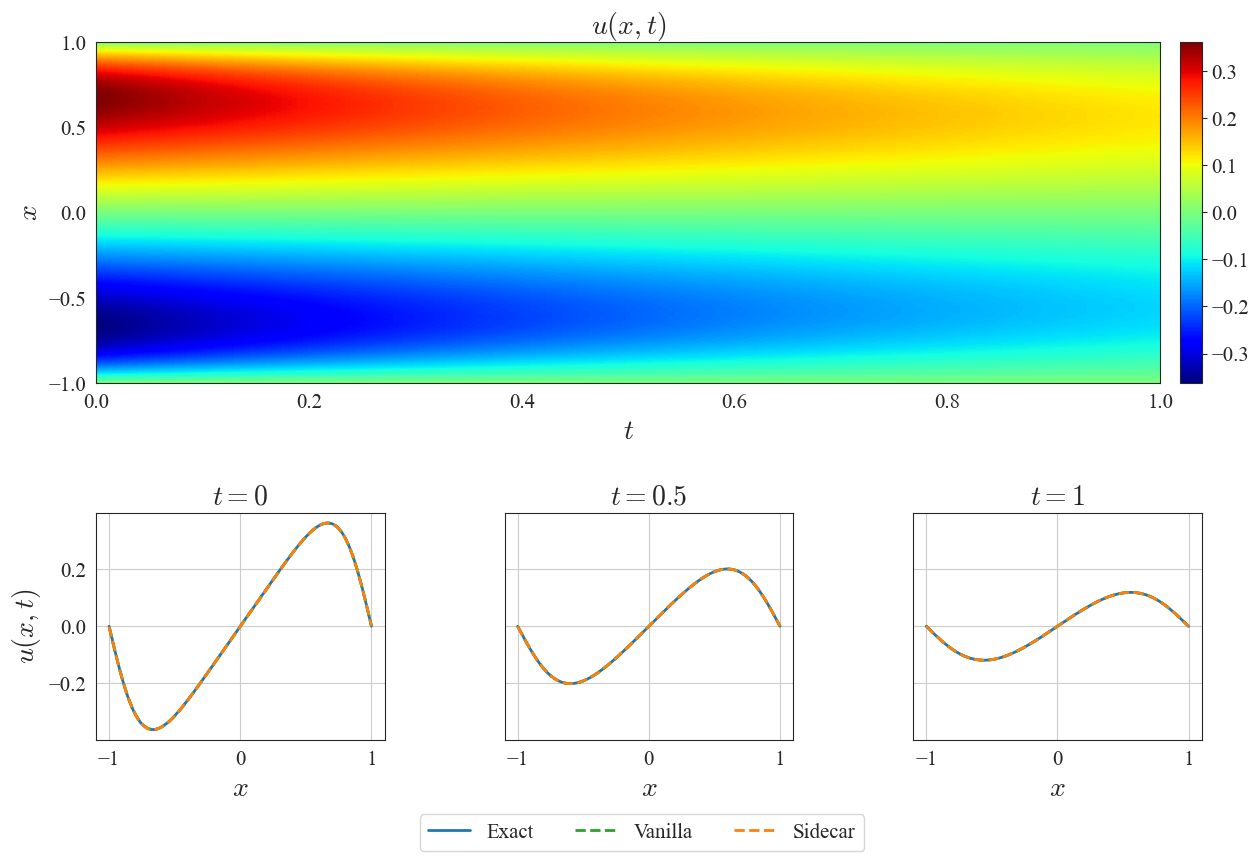

In [ ]:
u_pred_sidecar_matrix = u_pred_sidecar.reshape(len(x_test), len(t_test)).detach().cpu().numpy()
u_pred_matrix = u_pred.reshape(len(x_test), len(t_test)).detach().cpu().numpy()
u_exact_matrix = exact_solution(X_test).reshape(len(x_test), len(t_test)).detach().cpu().numpy()

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MultipleLocator

fig = plt.figure(figsize=(12, 8), constrained_layout=True)
# gs = gridspec.GridSpec(2, 3, height_ratios=[3, 2])
# gs.update(wspace=0.4, hspace=0.5)
gs = fig.add_gridspec(2, 3, height_ratios=[3, 2], wspace=0.15, hspace=0.1)

ax0 = fig.add_subplot(gs[0, :])
im = ax0.imshow(
    u_pred_matrix,
    interpolation='nearest',
    cmap='jet',
    extent=[0, 1, -1, 1],
    origin='lower',
    aspect='auto'
)
ax0.set_xlabel('$t$', fontsize=20)
ax0.set_ylabel('$x$', fontsize=20)
ax0.tick_params(labelsize=15)
major_locator = MultipleLocator(0.5)
ax0.yaxis.set_major_locator(major_locator)
ax0.set_title('$u(x,t)$', fontsize=20)


divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="2%", pad=0.2)  
cbar = fig.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=15)

ax1 = fig.add_subplot(gs[1, 0])
ax1.plot(x_test.cpu().numpy(), u_exact_matrix[:, 0], linewidth = 2, label='Exact')
ax1.plot(x_test.cpu().numpy(), u_pred_matrix[:, 0], linestyle = '--', linewidth = 2, color = 'tab:green', label='Vanilla')
ax1.plot(x_test.cpu().numpy(), u_pred_sidecar_matrix[:, 0], linestyle = '--', linewidth = 2, color = 'tab:orange', label='Sidecar')

ax1.set_xlabel('$x$', fontsize=20)
ax1.set_ylabel('$u(x,t)$', fontsize=20)
ax1.tick_params(labelsize=15)
ax1.set_title('$t=0$', fontsize=20)
ax1.legend(fontsize=15)
ax1.grid()

ax2 = fig.add_subplot(gs[1, 1], sharey=ax1)
mid_index = int(len(t_test) / 2)
ax2.plot(x_test.cpu().numpy(), u_exact_matrix[:, mid_index], linewidth = 2, label='Exact')
ax2.plot(x_test.cpu().numpy(), u_pred_matrix[:, mid_index], linestyle = '--', linewidth = 2, color = 'tab:green', label='Vanilla')
ax2.plot(x_test.cpu().numpy(), u_pred_sidecar_matrix[:, mid_index], linestyle = '--', linewidth = 2, color = 'tab:orange', label='Sidecar')
ax2.set_xlabel('$x$', fontsize=20)
# ax2.set_ylabel('$x$', fontsize=20)
ax2.tick_params(labelsize=15)
ax2.label_outer()
ax2.set_title('$t=0.5$', fontsize=20)
ax2.grid()
# ax2.legend(fontsize=15)

ax3 = fig.add_subplot(gs[1, 2], sharey=ax1)
ax3.plot(x_test.cpu().numpy(), u_exact_matrix[:, -1], linewidth = 2, label='Exact')
ax3.plot(x_test.cpu().numpy(), u_pred_matrix[:, -1], linestyle = '--', linewidth = 2, color = 'tab:green', label='Vanilla')
ax3.plot(x_test.cpu().numpy(), u_pred_sidecar_matrix[:, -1], linestyle = '--', linewidth = 2, color = 'tab:orange', label='Sidecar')
ax3.set_xlabel('$x$', fontsize=20)
# ax3.set_ylabel('$x$', fontsize=20)
ax3.tick_params(labelsize=15)
ax3.label_outer()
ax3.set_title('$t=1$', fontsize=20)
ax3.grid()
# ax3.legend(fontsize=15)

# plt.tight_layout()
handles, labels = [], []
for ax in [ax1]:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)
    ax.legend().remove() 

# fig.legend(handles, labels, loc='upper right')
fig.legend(handles, labels, loc='lower center', ncol=3, fontsize=15, bbox_to_anchor=(0.53, -0.07))

plt.savefig(f"/home/22040517r/sidecar/Sidecar/codes/parallel/simple_largeNu/burgers_solutions.pdf", bbox_inches='tight')
plt.show()